#### Apo Challenge

## Preprocessing 

__Note:__

To run this code, you need a kaggle account, to install the kaggle API (see https://github.com/Kaggle/kaggle-api), and to create an API token.

Besides the standard imports, you also need the following dependencies,:
  * imbalanced-learn (https://imbalanced-learn.org/stable/)
  * pandas-profiling (https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/#)
  * Phi K (https://anaconda.org/conda-forge/phik) or (https://phik.readthedocs.io/en/latest/)
  
Although the data is written in German, the notebook is written in English in accordance with the coding language. 

For variable descriptions, please refer to the respective Kaggle challenge.
  
Last update: January 19th, 2021
  

In [1]:
reset -fs

In [2]:
#Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(palette = 'magma')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats

#for descriptive analyses
from pandas_profiling import ProfileReport
from imblearn.pipeline import Pipeline

#For evaluation of correlations of at least nominal features
import phik

#For upsampling data
from imblearn.over_sampling import SMOTENC

#For import from notebooks
#!pip install nbimporter
import nbimporter

from category_encoders import MEstimateEncoder

In [3]:
#Import functions
from Stored_Functions import adapt_writing, adapt_writing_test

Importing Jupyter notebook from Stored_Functions.ipynb


In [4]:
#OPTIONAL
#Disable scientific notation for floats
pd.options.display.float_format = '{:,}'.format

#Enable viewing more (in this case: all) features of a dataset 
pd.set_option('display.max_columns', 500)

#### __Get Data__

The data is directly downloaded from Kaggle.

In [8]:
#Download data from kaggle
#!kaggle competitions download -c dataanalyticschallenge61

In [9]:
#Unzip into new "data" folder 
#!unzip -d data dataanalyticschallenge61.zip

In [10]:
#Load train data into Pandas dataframe
train = pd.read_csv('data/TrainData.csv', delimiter = ';', encoding = 'iso-8859-1')
train.head(2)

,Stammnummer,Zielvariable,Tag,Monat,Dauer,Anruf-ID,Alter,Geschlecht,Art der Anstellung,Familienstand,Schulabschluß,Ausfall Kredit,Kontostand,Haus,Kredit,Kontaktart,Anzahl der Ansprachen,Tage seit letzter Kampagne,Anzahl Kontakte letzte Kampagne,Ergebnis letzte Kampagne
0,432148809,nein,27,may,166,623,30,w,Arbeiter,verheiratet,Abitur,nein,-202,nein,nein,Unbekannt,2,nan,0,Unbekannt
1,432184318,nein,26,oct,183,1992,42,w,Management,verheiratet,Studium,nein,2463,nein,nein,Handy,2,nan,0,Unbekannt


#### __Train-Validation-Split__

For model evaluation, the training dataset is splitted into training set and validation set.
The validation dataset will only come into play in model evaluation.

In [11]:
#Split dataset into train and validation subsets
X_train, X_val, y_train, y_val = train_test_split(train.drop('Zielvariable', axis = 1), train.Zielvariable, test_size = .2, random_state = 42, 
                                                  stratify = train.Zielvariable, shuffle = True)
#Combine features and targets in dataframes
#train
df_train = pd.concat([pd.Series(y_train, name ='Zielvariable'), pd.DataFrame(X_train, columns = train.drop('Zielvariable', axis = 1).columns)], 
                     axis = 1)
df_train.reset_index(inplace = True)
df_train.drop('index', axis = 1, inplace = True)

#validation
df_val = pd.concat([pd.Series(y_val, name ='Zielvariable'), pd.DataFrame(X_val, columns = train.drop('Zielvariable', axis = 1).columns)], axis = 1)
df_val.reset_index(inplace = True)
df_val.drop('index', axis = 1, inplace = True)

#Show first 5 samples of train dataframe 
df_train.head(2)

,Zielvariable,Stammnummer,Tag,Monat,Dauer,Anruf-ID,Alter,Geschlecht,Art der Anstellung,Familienstand,Schulabschluß,Ausfall Kredit,Kontostand,Haus,Kredit,Kontaktart,Anzahl der Ansprachen,Tage seit letzter Kampagne,Anzahl Kontakte letzte Kampagne,Ergebnis letzte Kampagne
0,nein,432171141,30,jan,588,47936933,37,m,Arbeiter,single,Abitur,nein,5742,ja,ja,Handy,1,nan,0,Unbekannt
1,nein,432180879,15,may,206,45795150,34,m,Arbeiter,geschieden,Real-/Hauptschule,nein,0,ja,nein,Handy,5,nan,0,Unbekannt


In [12]:
#Get information on training setsize and variables' data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25184 entries, 0 to 25183
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Zielvariable                     25184 non-null  object 
 1   Stammnummer                      25184 non-null  int64  
 2   Tag                              25184 non-null  int64  
 3   Monat                            25184 non-null  object 
 4   Dauer                            25184 non-null  int64  
 5   Anruf-ID                         25184 non-null  int64  
 6   Alter                            25184 non-null  int64  
 7   Geschlecht                       25184 non-null  object 
 8   Art der Anstellung               25184 non-null  object 
 9   Familienstand                    25184 non-null  object 
 10  Schulabschluß                    25184 non-null  object 
 11  Ausfall Kredit                   25184 non-null  object 
 12  Kontostand        

In [13]:
#Apply function to training data
adapt_writing(df_train)  

,zielvariable,stammnummer,tag,monat,dauer,anruf_id,alter,geschlecht,art_der_anstellung,familienstand,schulabschluß,ausfall_kredit,kontostand,haus,kredit,kontaktart,anzahl_der_ansprachen,tage_seit_letzter_kampagne,anzahl_kontakte_letzte_kampagne,ergebnis_letzte_kampagne
0,nein,432171141,30,jan,588,47936933,37,m,arbeiter,single,abitur,nein,5742,ja,ja,handy,1,nan,0,unbekannt
1,nein,432180879,15,may,206,45795150,34,m,arbeiter,geschieden,real-/hauptschule,nein,0,ja,nein,handy,5,nan,0,unbekannt
2,nein,432170419,28,jan,262,42140131,31,w,management,single,studium,nein,308,ja,ja,handy,2,268.0,2,sonstiges
3,nein,432172706,5,feb,75,26814226,57,w,management,verheiratet,abitur,nein,287,nein,ja,handy,1,8.0,2,sonstiges
4,nein,432172737,5,feb,166,1065521,40,m,management,verheiratet,abitur,nein,18,ja,nein,handy,1,8.0,2,sonstiges
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25179,nein,432166201,29,aug,121,16326313,49,m,management,single,abitur,nein,0,nein,nein,handy,2,nan,0,unbekannt
25180,nein,432175046,17,apr,82,6598396,79,m,rentner,verheiratet,real-/hauptschule,nein,3481,nein,nein,festnetz,4,nan,0,unbekannt
25181,nein,432185886,26,apr,116,42885938,36,m,management,verheiratet,studium,nein,2183,ja,nein,handy,2,nan,0,unbekannt
25182,nein,432163885,19,aug,198,12139161,32,w,management,verheiratet,studium,nein,0,nein,nein,handy,6,nan,0,unbekannt


In [14]:
#Stammnummer and anruf id are unique values and have no predictive value. Therefore, they are dropped from the dataframe, 
#given that there are no duplicates. In case of duplicates, these are printed.
if df_train.duplicated(subset = ['stammnummer', 'anruf_id']).sum() == 0:
    df_train.drop(['stammnummer', 'anruf_id'], axis = 1, inplace = True)
else:
    print(df_train[df_train.duplicated()])

Overall, the dataset contains  1907 outliers.


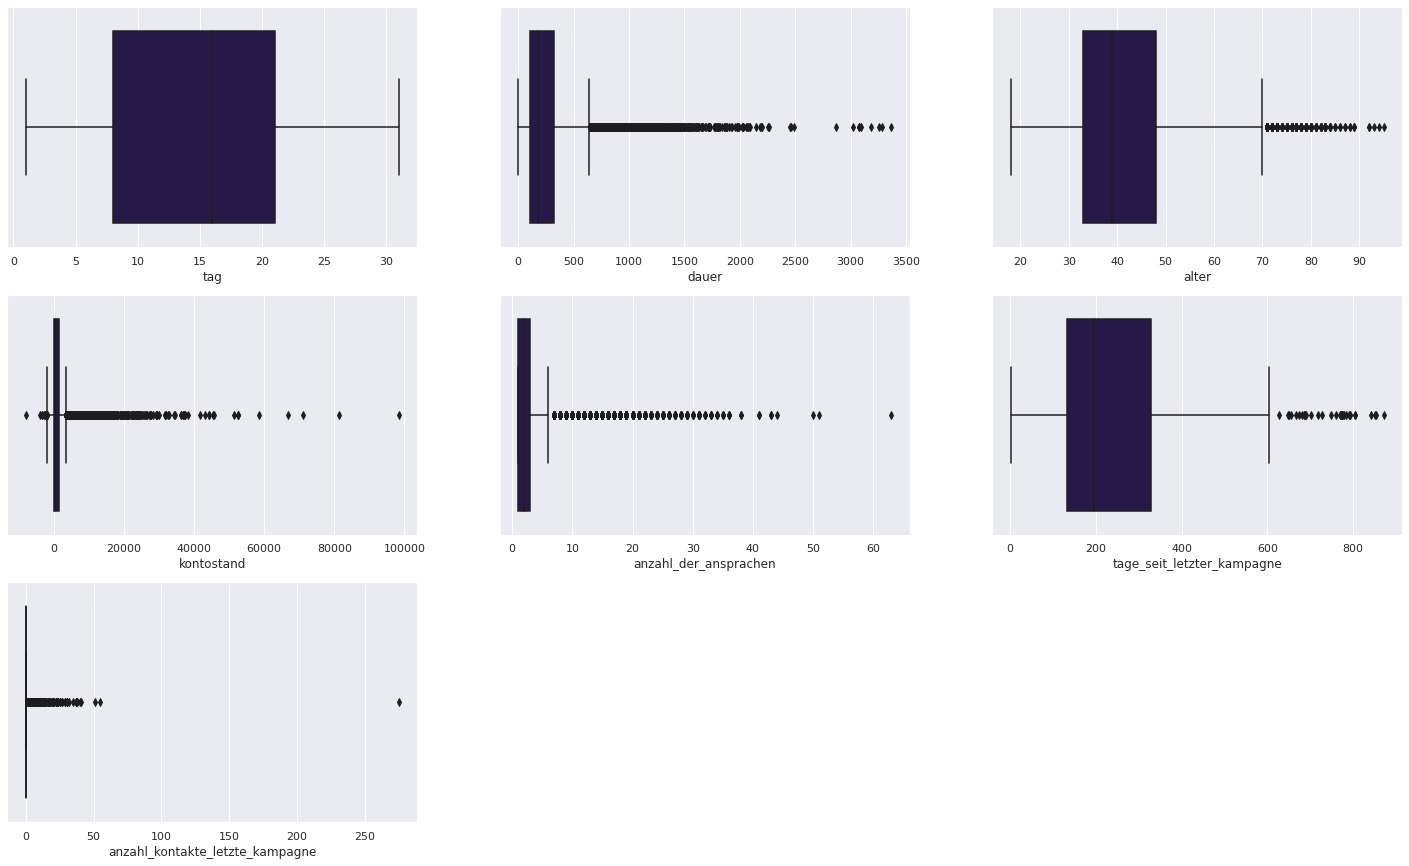

In [15]:
#Explore outliers based on z-scores: A value is considered an outlier if its z-score is greater than 3.
num = df_train.select_dtypes('number') #select numeric features
z = np.abs(stats.zscore(num)) #compute z-scores
print('Overall, the dataset contains ', len(df_train[(z > 3)]), 'outliers.') #print total number of outliers

#Display boxplots of numerical features to vvisualize outliers
subplot = 1 #index of subplot
plt.figure(figsize = (25, 15)) #set figure size
for col in df_train.select_dtypes('number').columns: 
    plt.subplot(3, 3,subplot) #display boxplots in a 3x3 grid
    sns.boxplot(x = df_train.select_dtypes('number')[col]) #boxplot for every numerical feature
    subplot += 1

Outliers are not removed from the dataset to improve model generalization. However, I'll use the sklearn RobustScaler() when rescaling the data to account for outliers. 

In [16]:
#Print profile report for data exploration including descriptive statistics, missing values, correlations, interactions.
ProfileReport(df_train)

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

exception calling callback for <Future at 0x7f73665dc5f8 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/_parallel_ba

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1)}

I investigate the connection of prior contact and effectiveness of prior contact: It is reasonable to assume that the result of prior customer contact is
dependent on whether there was any contact. I therefore explore the value counts of prior contact results grouped bx prior contact frequency.

In [13]:
print('Prior contact: ', df_train.query('anzahl_kontakte_letzte_kampagne > 0').ergebnis_letzte_kampagne.value_counts())
print('\n No prior contact: ', df_train.query('anzahl_kontakte_letzte_kampagne == 0').ergebnis_letzte_kampagne.value_counts())

Prior contact:  kein erfolg    2687
sonstiges      1060
erfolg          828
unbekannt         2
Name: ergebnis_letzte_kampagne, dtype: int64

 No prior contact:  unbekannt    20607
Name: ergebnis_letzte_kampagne, dtype: int64


--> If there was no prior contact, result of prior contact is set to 'unbekannt'. 
We can combine both features without losing information.

In [14]:
#Compute new variable combining anzahl_kontakte_letzte_kampagne and ergebnis_letzte_kampagne: 
#Set value of new feature to ergebnis_letzte_kampagne
df_train['letzte_kampagne'] = df_train.ergebnis_letzte_kampagne #compute new feature 'letzte_kampagne' and by default eqal its value to ergebnis_letzte_kampagne
#If there was no prior contact, letzte Kampagne is set to 'kein kontakt'
for i in range(len(df_train)):
    if df_train.loc[i, 'anzahl_kontakte_letzte_kampagne'] == 0:
        df_train.loc[i,'letzte_kampagne'] = 'kein kontakt' 
        
#drop the original features
df_train.drop(['anzahl_kontakte_letzte_kampagne', 'ergebnis_letzte_kampagne'], axis = 1, inplace = True)

Also, the number of days since the last contact is correlated with 'letzte kampagne': If there was no prior contact, the number of days equals np.nan.
We change the number of days feature to categorical: 

In [15]:
#Investigate the connection of prior contact and number of days ince prior contact
print('If there was no contact:', df_train.query('letzte_kampagne == "kein kontakt"').tage_seit_letzter_kampagne.value_counts())
print('\n If there was contact:',df_train.query('letzte_kampagne != "kein kontakt"').tage_seit_letzter_kampagne.value_counts())
print('\n If there was contact:',df_train.query('letzte_kampagne != "kein kontakt"').tage_seit_letzter_kampagne.isna().sum(), ' missing values')

If there was no contact: Series([], Name: tage_seit_letzter_kampagne, dtype: int64)

 If there was contact: 182.0    85
92.0     82
91.0     76
183.0    72
181.0    68
         ..
484.0     1
667.0     1
543.0     1
393.0     1
383.0     1
Name: tage_seit_letzter_kampagne, Length: 490, dtype: int64

 If there was contact: 0  missing values


--> If there was no prior contact, tage_seit_letzter_kampagne is NaN. 

In [16]:
#We can fill in the NaNs of tage_seit_letzter_kampagne with 0 if there was no prior contact.
df_train.tage_seit_letzter_kampagne.fillna(0, inplace = True)

In [17]:
#Reduce number of classes in art_der_anstellung to 4 classes by summmarizing the different job types ('angestellt') as well as people not working
#('nicht erwerbstätig'). Student and #self-reliant jobs (selbsätndig and gründer) form one class, repsectively.
# Missing values are replaced by the mode 'angestellt'.
df_train['erwerbstaetigkeit'] = 'angestellt'
for i in range(len(df_train)):
    if df_train.loc[i, 'art_der_anstellung'] in ['hausfrau', 'arbeitslos', 'rentner']:
        df_train.loc[i,'erwerbstaetigkeit'] = 'nicht erwerbstätig'
    elif df_train.loc[i, 'art_der_anstellung'] == 'student':
        df_train.loc[i,'erwerbstaetigkeit'] = 'student'
    elif df_train.loc[i, 'art_der_anstellung'] in ['selbständig', 'gründer']:
        df_train.loc[i,'erwerbstaetigkeit'] = 'selbständig'

#Print Phi -K of new and old feature
import phik
df_train[['zielvariable', 'erwerbstaetigkeit', 'art_der_anstellung']].phik_matrix().round(3)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1)}

In [ ]:
#The new feature captures the correlation with the target to the greater part, so we drop the original feature 
#art_der_anstellung.
df_train.drop('art_der_anstellung', axis = 1, inplace = True)

In [ ]:
#The missings/ unbekannt labels are replaced by the column's mode
cols = ['schulabschluß', 'kontaktart', 'letzte_kampagne']
for col in cols:
    df_train[col].replace('unbekannt', np.nan, inplace = True)
    df_train[col].fillna(df_train[col].mode()[0], inplace = True)

In [ ]:
#Save train data
df_train.to_json('train_preprocessed.json')

#Apply preprocessing to validation data and save dataset
adapt_writing_test(df_val)
df_val.to_json('validation_preprocessed.json')